#Install pytorch geometric

In [ ]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 30.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=8f8b29effda265a2df74ebbcf337fa3b35915e022f7023d4f0f86277d2a470f9
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


#Install Essential Libraries


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv, global_add_pool

#Visualization Functions


In [ ]:
def visualize(h, color, title):
    z = TSNE(n_components=2, random_state=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.title('Visualization using 2-componenet of TSNE / '+ title)
    plt.show()


def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):

    plt.figure(figsize=(12,6),linewidth = 7, edgecolor="whitesmoke")
    n = n_epochs

    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss,'b',marker=".")

    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')

    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)

    # plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

#Node Classification

##Read the Dataset

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


##Dataset Details


In [ ]:
def Information_Extaction(dataset):
  print('There is %d graph in the dataset.' %len(dataset))
  print('The graph has %d nodes.' %dataset[0].num_nodes)
  print('The graph has %d edges.' %dataset[0].num_edges)
  print('Each node has %d features.' %dataset[0].num_features)
  print('These are %d classes.'  %dataset.num_classes)
  print("The Average degree for each node is %d." %round((2*dataset[0].num_edges) / (dataset[0].num_nodes),4))
  print('There are %d mask training nodes in the dataset.' %dataset[0].train_mask.sum().item())
  return

In [ ]:
Information_Extaction(dataset)

There is 1 graph in the dataset.
The graph has 2708 nodes.
The graph has 10556 edges.
Each node has 1433 features.
These are 7 classes.
The Average degree for each node is 7.
There are 140 mask training nodes in the dataset.


##Visualizing before training

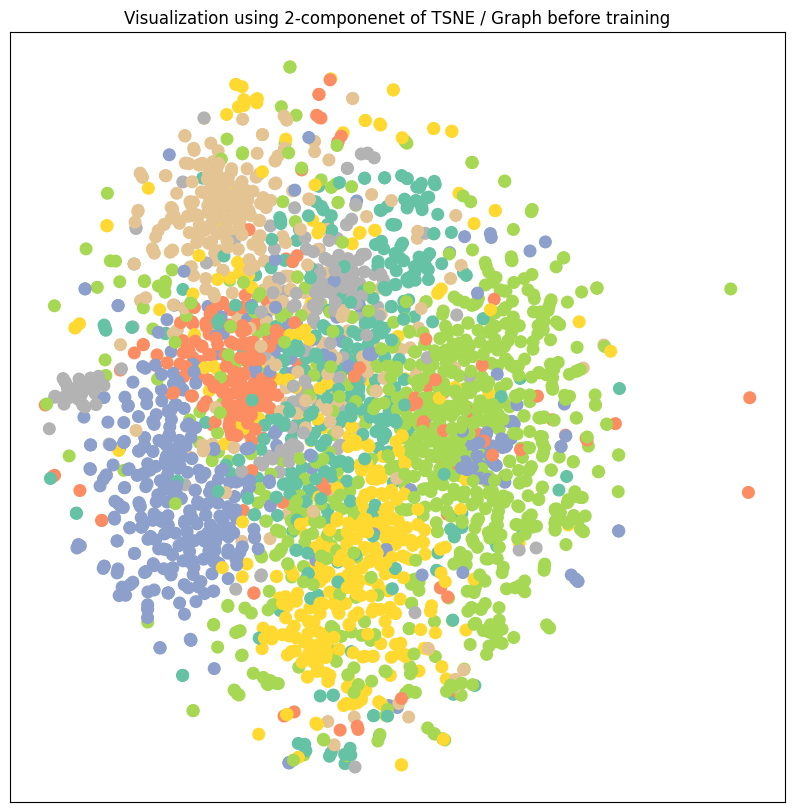

In [ ]:
visualize(dataset[0].x, color=dataset[0].y, title = "Graph before training")

##Additional Libraries for GNN


In [ ]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

##GCN Implementation


###GCN Class

In [ ]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        hidden_channel=8,
        ):

        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


###Evaluation class

In [ ]:
class Leaning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        data,
        model,
        learning_rate=0.01,
        n_epochs=100,
        min_valid_loss=np.inf,
        ):
      super().__init__()
      self.data = data
      self.model = model
      self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.CrossEntropyLoss()
      self.n_epochs = n_epochs
      self.min_valid_loss = min_valid_loss

    def train_one_epoch(self):
          save_model_flag = False
          self.model.train()
          self.optimizer.zero_grad()

          out = self.model(self.data)
          train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
          validation_loss = self.criterion(out[self.data.val_mask], data.y[self.data.val_mask])

          pred = out.argmax(dim=1)
          train_correct = pred[self.data.train_mask] == self.data.y[self.data.train_mask]
          train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
          validation_correct = pred[self.data.val_mask] == data.y[self.data.val_mask]
          validation_acc = int(validation_correct.sum()) / int(self.data.val_mask.sum())

          if self.min_valid_loss > validation_loss:
              save_model_flag = True

          train_loss.backward()
          self.optimizer.step()

          return train_loss, train_acc, validation_loss, validation_acc, save_model_flag

    def train(self, best_model_saving_path):
      list_train_loss, list_train_acc, list_val_loss, list_val_acc = [], [], [], []

      for epoch in range(1, self.n_epochs+1):
        train_loss, train_acc, validation_loss, validation_acc, save_model_flag = self.train_one_epoch()
        list_train_loss.append(float(train_loss.detach()))
        list_train_acc.append(train_acc)
        list_val_loss.append(float(validation_loss.detach()))
        list_val_acc.append(validation_acc)
        print(f'Epoch: {epoch:03d}, Trian Loss: {train_loss:.4f}, Trian Accuracy: {train_acc:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}')

        if save_model_flag:
          self.min_valid_loss = validation_loss
          print(f" ******* Best model updated in epoch: {epoch}, Best validation loss: {self.min_valid_loss:.4f} *******")
          torch.save(self.model, best_model_saving_path)

      return list_train_loss, list_train_acc, list_val_loss, list_val_acc

    def test(self, best_model_path):
        model = torch.load(best_model_path)
        model.eval()
        out = model(self.data)
        test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == self.data.y[self.data.test_mask]
        test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
        return test_acc, test_loss

###Applying model

In [ ]:
gcn_model = GCN(hidden_channel = 8)
print(gcn_model)



GCN(
  (conv1): GCNConv(1433, 8)
  (conv2): GCNConv(8, 7)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

In [ ]:
evaluate_GCN = Leaning_Evaluation(data=data,
                                   model = gcn_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN.train(best_model_saving_path='GCN2_8_best_model.pth')

Epoch: 001, Trian Loss: 1.9454, Trian Accuracy: 0.1643, Validation Loss: 1.9467, Validation Accuracy: 0.1380
 ******* Best model updated in epoch: 1, Best validation loss: 1.9467 *******
Epoch: 002, Trian Loss: 1.9410, Trian Accuracy: 0.1857, Validation Loss: 1.9454, Validation Accuracy: 0.1660
 ******* Best model updated in epoch: 2, Best validation loss: 1.9454 *******
Epoch: 003, Trian Loss: 1.9352, Trian Accuracy: 0.3071, Validation Loss: 1.9414, Validation Accuracy: 0.2220
 ******* Best model updated in epoch: 3, Best validation loss: 1.9414 *******
Epoch: 004, Trian Loss: 1.9280, Trian Accuracy: 0.4143, Validation Loss: 1.9394, Validation Accuracy: 0.3040
 ******* Best model updated in epoch: 4, Best validation loss: 1.9394 *******
Epoch: 005, Trian Loss: 1.9185, Trian Accuracy: 0.5429, Validation Loss: 1.9348, Validation Accuracy: 0.3440
 ******* Best model updated in epoch: 5, Best validation loss: 1.9348 *******
Epoch: 006, Trian Loss: 1.9120, Trian Accuracy: 0.4929, Validatio

In [ ]:
test_acc, test_loss = evaluate_GCN.test(best_model_path='GCN2_8_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7710, Test loss: 0.8591


###Visualising the results

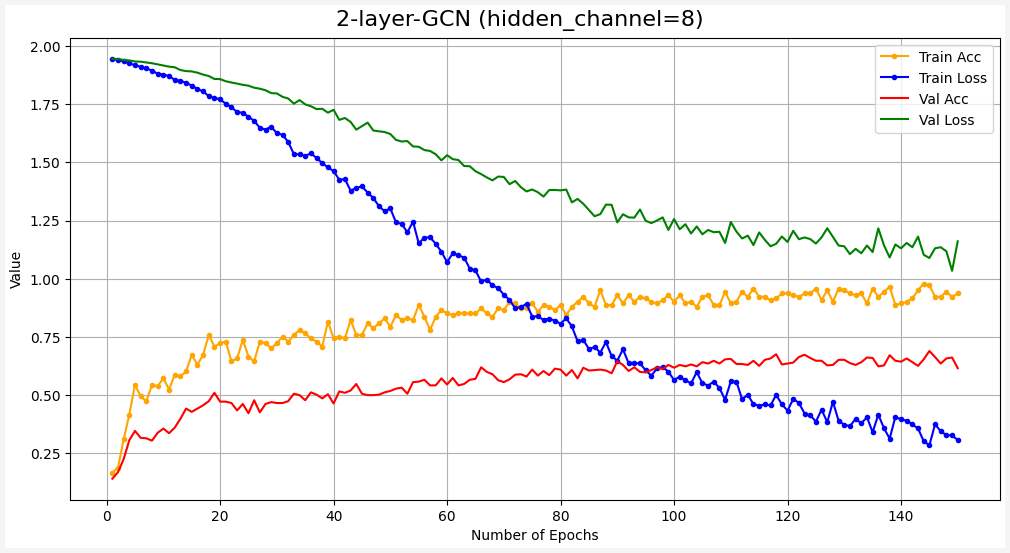

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN.n_epochs, title='2-layer-GCN (hidden_channel=8)')

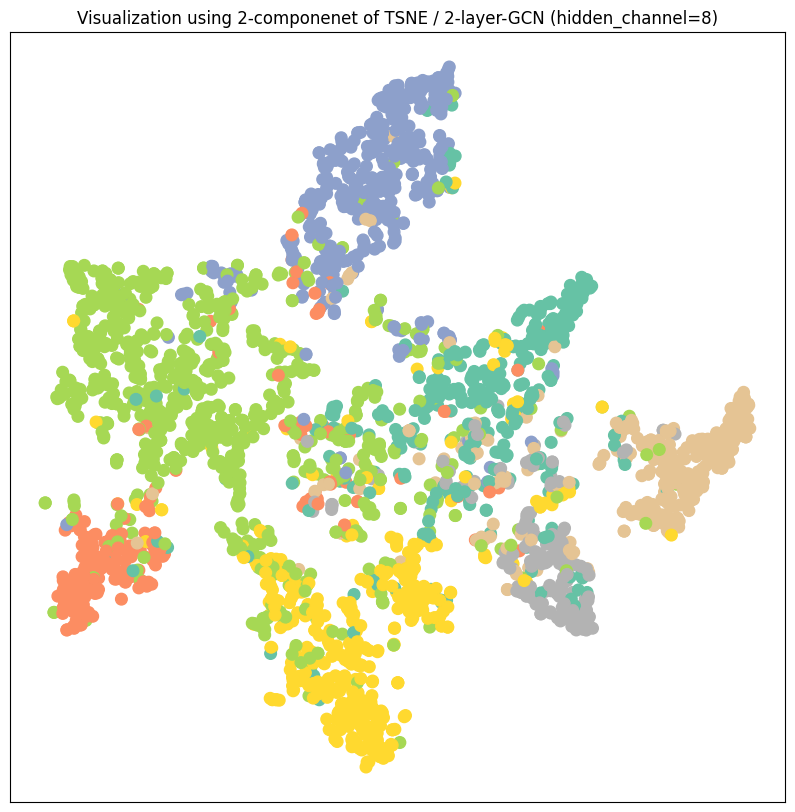

In [ ]:
model = torch.load('GCN2_8_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='2-layer-GCN (hidden_channel=8)')

#Graph classification

##Read the Dataset

In [ ]:
dataset = TUDataset(root='/tmp/AIDS', name='AIDS', transform=NormalizeFeatures())

Extracting /tmp/AIDS/AIDS/AIDS.zip
Processing...
Done!


##Split the Dataset


In [ ]:
def split_data(dataset, train_split_percentage):
  cut_index = int(len(dataset) * train_split_percentage)
  dataset = dataset.shuffle()
  return dataset[:cut_index], dataset[cut_index:]

In [ ]:
train_dataset, test_dataset = split_data(dataset, train_split_percentage=0.8)
print(f'Number of graphs in the Train Dataset: {len(train_dataset)}')
print(f'Number of graphs in the Test Dataset: {len(test_dataset)}')

Number of graphs in the Train Dataset: 1600
Number of graphs in the Test Dataset: 400


##Batch Generator

In [ ]:
def batch_generator(train_dataset, test_dataset, batch_size, shuffle=True):
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  return train_data_loader, test_data_loader

In [ ]:
train_data_loader, test_data_loader =  batch_generator(train_dataset, test_dataset, batch_size=64)

for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Batch 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2088], x=[1005, 38], edge_attr=[2088, 3], y=[64], batch=[1005], ptr=[65])

Batch 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2216], x=[1075, 38], edge_attr=[2216, 3], y=[64], batch=[1075], ptr=[65])

Batch 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2390], x=[1156, 38], edge_attr=[2390, 3], y=[64], batch=[1156], ptr=[65])

Batch 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2040], x=[981, 38], edge_attr=[2040, 3], y=[64], batch=[981], ptr=[65])

Batch 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2082], x=[1004, 38], edge_attr=[2082, 3], y=[64], batch=[1004], ptr=[65])

Batch 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1678], x=[816, 38], edge_attr=[1678, 3], y=[64], batch=[816], ptr=[65])

Batch 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2372], x=[1139, 38], e

##GCN ADD pooling class implementation

In [ ]:
class GCN_Add_Pooling(torch.nn.Module):

    def __init__(self, hidden_channels, aggregation):
        super(GCN_Add_Pooling, self).__init__()
        torch.manual_seed(12345)
        if type(aggregation) != list:
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels, aggr=aggregation)
          self.conv2 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv3 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv4 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.lin = Linear(hidden_channels, dataset.num_classes)
        else:
          i=1
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv2 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv3 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv4 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          self.lin = Linear(hidden_channels*(len(aggregation)**(i+1)), dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


##GraphSage implementation

In [ ]:
class Graph_Sage(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Sage, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)


        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

##Learning evaluation class

In [ ]:
class Leaning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        model,
        learning_rate=0.006,
        best_results=[0, 0, 0],
        ):

      super().__init__()
      self.model = model
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.CrossEntropyLoss()
      self.best_results = best_results

    def train(self, data_loader):
        self.model.train()

        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss = self.criterion(out, data.y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def evaluate(self, data_loader):
        self.model.eval()

        correct, loss = 0, 0
        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss += self.criterion(out, data.y)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
        return correct / len(data_loader.dataset), loss/ len(data_loader.dataset)

    def train_and_evaluate(self, train_data_loader, test_data_loader, n_epochs=200):

      list_train_acc, list_train_loss, list_test_acc, list_test_loss = [], [], [], []
      print('Train and Evaluation started...')
      for epoch in range(1, n_epochs+1):
          self.train(train_data_loader)

          train_accuracy, train_loss = self.evaluate(train_data_loader)
          list_train_acc.append(train_accuracy)
          list_train_loss.append(float(train_loss.detach()))

          test_accuracy, test_loss = self.evaluate(test_data_loader)
          if self.best_results[-1] + self.best_results[1] < test_accuracy + train_accuracy :
            self.best_results[0], self.best_results[1], self.best_results[-1] = epoch, train_accuracy ,test_accuracy

          list_test_acc.append(test_accuracy)
          list_test_loss.append(float(test_loss.detach()))

          print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

      print('---------------------------------------------------')
      print('Train and Evaluation finished...')
      print(f'Best Results of the model : Epoch: {self.best_results[0]:03d}, Train Accuracy: {self.best_results[1]:.4f}, Test Accuracy: {self.best_results[-1]:.4f}')
      return list_train_acc, list_train_loss, list_test_acc, list_test_loss


##GCN ADD pooling model

In [ ]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='add')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(38, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


###Fit the model

In [ ]:
evaluate_GCN_add = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_add.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)


Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.7344, Train Loss: 0.0091, Test Accuracy: 0.7775, Test Loss: 0.0100
Epoch: 002, Train Accuracy: 0.7419, Train Loss: 0.0076, Test Accuracy: 0.7600, Test Loss: 0.0085
Epoch: 003, Train Accuracy: 0.7319, Train Loss: 0.0073, Test Accuracy: 0.7450, Test Loss: 0.0084
Epoch: 004, Train Accuracy: 0.7744, Train Loss: 0.0067, Test Accuracy: 0.7750, Test Loss: 0.0074
Epoch: 005, Train Accuracy: 0.8050, Train Loss: 0.0063, Test Accuracy: 0.8100, Test Loss: 0.0074
Epoch: 006, Train Accuracy: 0.8488, Train Loss: 0.0061, Test Accuracy: 0.8525, Test Loss: 0.0069
Epoch: 007, Train Accuracy: 0.8575, Train Loss: 0.0057, Test Accuracy: 0.8525, Test Loss: 0.0074
Epoch: 008, Train Accuracy: 0.8137, Train Loss: 0.0059, Test Accuracy: 0.8225, Test Loss: 0.0070
Epoch: 009, Train Accuracy: 0.8750, Train Loss: 0.0053, Test Accuracy: 0.8700, Test Loss: 0.0067
Epoch: 010, Train Accuracy: 0.8838, Train Loss: 0.0051, Test Accuracy: 0.8850, Test Loss: 0.005

###Visualizing results

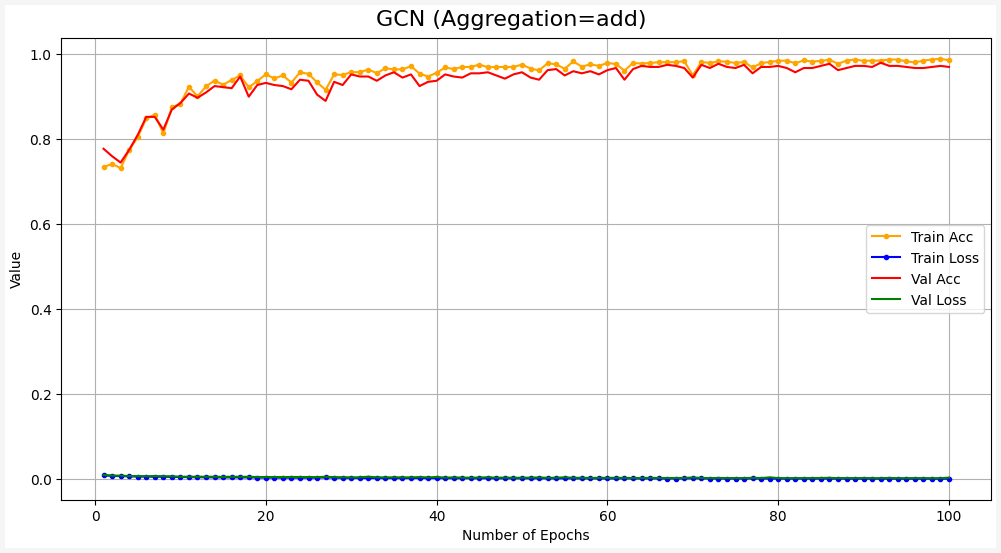

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=add)')

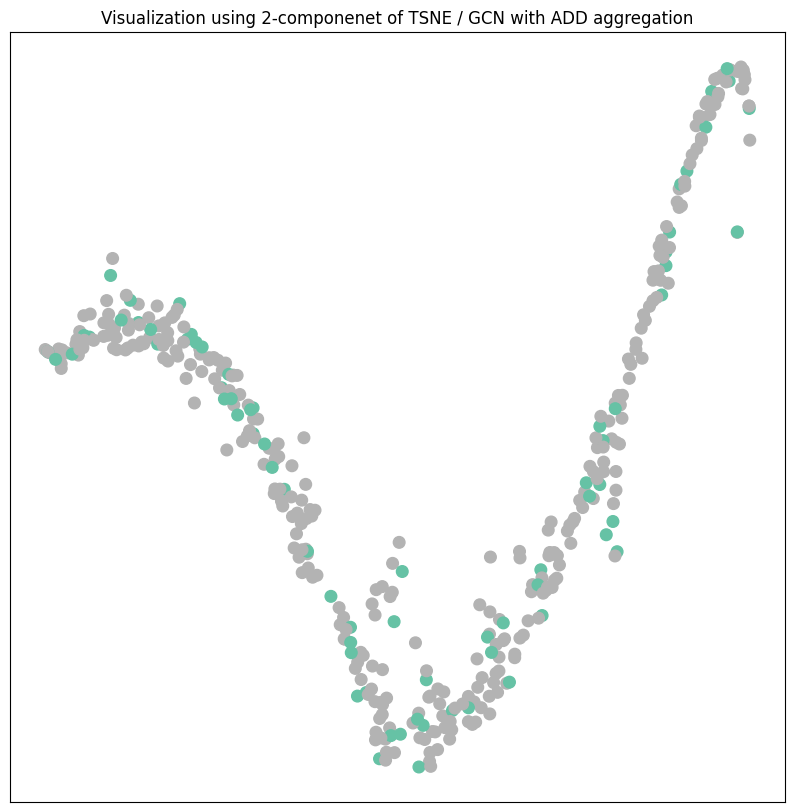

In [ ]:
test_data_loader = DataLoader(test_dataset, batch_size=400, shuffle=True)
for data in test_data_loader:
  batch = data
out = model(test_dataset.x, test_dataset.edge_index, data.batch)
visualize(out, color=test_dataset.y, title='GCN with ADD aggregation')

##Graph Sage model

In [ ]:
model = Graph_Sage(hidden_channels=64)
print(model)

Graph_Sage(
  (conv1): SAGEConv(38, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (conv4): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


###Fit the model

In [ ]:
evaluate_GraphSage = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphSage.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.7963, Train Loss: 0.0109, Test Accuracy: 0.8150, Test Loss: 0.0017
Epoch: 002, Train Accuracy: 0.7475, Train Loss: 0.0091, Test Accuracy: 0.7650, Test Loss: 0.0014
Epoch: 003, Train Accuracy: 0.7606, Train Loss: 0.0082, Test Accuracy: 0.7600, Test Loss: 0.0013
Epoch: 004, Train Accuracy: 0.7706, Train Loss: 0.0073, Test Accuracy: 0.7800, Test Loss: 0.0012
Epoch: 005, Train Accuracy: 0.8037, Train Loss: 0.0071, Test Accuracy: 0.8100, Test Loss: 0.0011
Epoch: 006, Train Accuracy: 0.7588, Train Loss: 0.0068, Test Accuracy: 0.7625, Test Loss: 0.0011
Epoch: 007, Train Accuracy: 0.8269, Train Loss: 0.0065, Test Accuracy: 0.8425, Test Loss: 0.0010
Epoch: 008, Train Accuracy: 0.8231, Train Loss: 0.0063, Test Accuracy: 0.8475, Test Loss: 0.0010
Epoch: 009, Train Accuracy: 0.8544, Train Loss: 0.0057, Test Accuracy: 0.8550, Test Loss: 0.0009
Epoch: 010, Train Accuracy: 0.8562, Train Loss: 0.0056, Test Accuracy: 0.8575, Test Loss: 0.000

###Visualizing results

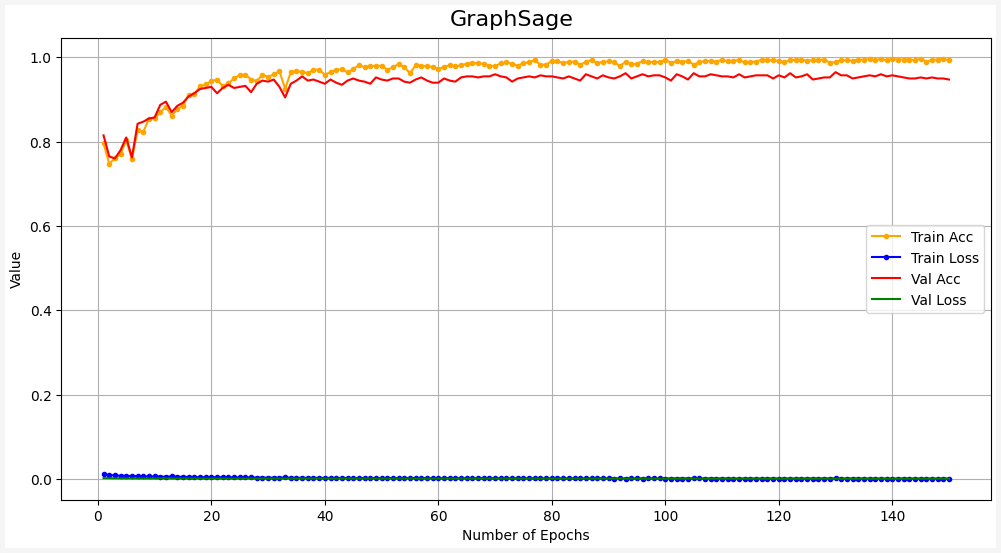

In [ ]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='GraphSage')

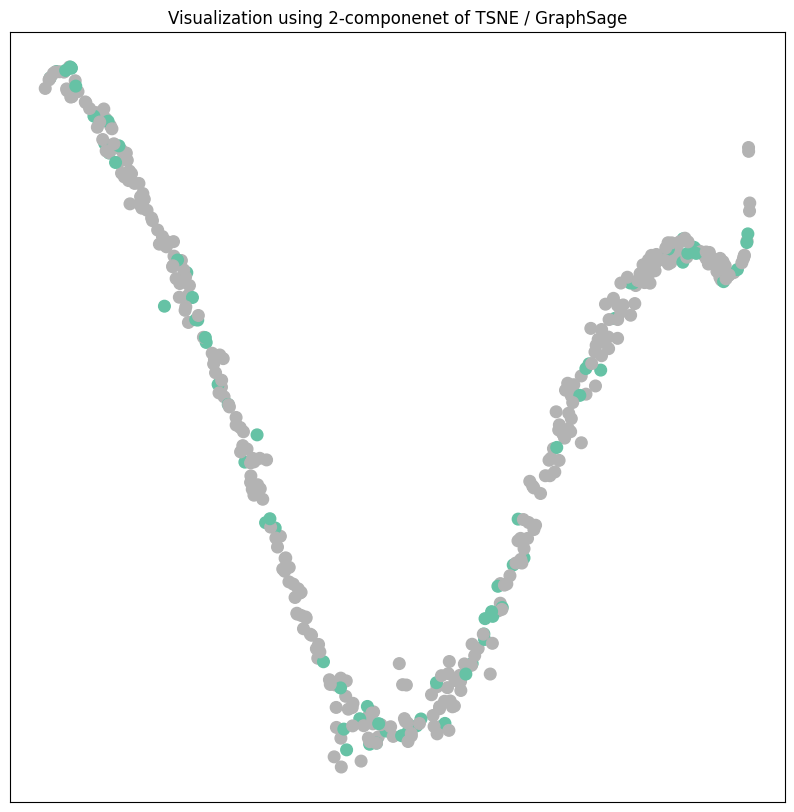

In [ ]:
test_data_loader = DataLoader(test_dataset, batch_size=400, shuffle=True)
for data in test_data_loader:
  batch = data
out = model(test_dataset.x, test_dataset.edge_index, data.batch)
visualize(out, color=test_dataset.y, title='GraphSage')